In [196]:
import scipy.io
import matplotlib.pyplot as plt
import math
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
import numpy as np
import numpy.testing as testing
import cv2
from skimage import morphology, segmentation
from keras.layers import Cropping2D, ZeroPadding2D, Input
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage

In [197]:
from matplotlib.colors import ListedColormap


In [198]:
cmap = ListedColormap(['darkblue', 'skyblue', 'blue', 'yellow', 'darkorange', 'darkred'])
# Load the MATLAB file
mat_data = scipy.io.loadmat('Brain.mat')

# Extract the MRI slices and presegmented images
mri_slices = mat_data['T1']
segmented_slices = mat_data['label']

In [199]:
def normalize_array(image):
    min_value = np.min(image)
    max_value = np.max(image)
    normalized_image = ((image - min_value) / (max_value - min_value))*255
    if max_value != 0:
        normalized_arr = normalized_image
    else:
        normalized_arr = image  # Handles case when max_value is 0 to avoid division by zero
    return normalized_arr

In [200]:
mri_slices = mat_data['T1']
segmented_slices = mat_data['label']

print(mri_slices[:,:,2])
print(segmented_slices[:,:,2])

[[ 7431.491   7193.863   6837.42   ...  2322.4797  2441.294   2560.1082]
 [ 6956.2344  7550.305   7669.1196 ...  2560.1082  2203.6655  2084.8513]
 [ 6837.42    7669.1196  8144.3765 ...  2678.9224  2441.294   2203.6655]
 ...
 [ 7193.863   7193.863   7193.863  ... 14916.787  15035.601  13728.645 ]
 [ 6956.2344  7075.0483  7193.863  ... 16104.929  15510.857  13609.83  ]
 [ 6718.606   6837.42    7193.863  ... 16580.186  15748.486  14560.344 ]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [201]:
ground_truth = normalize_array(segmented_slices[:,:,2])
image = normalize_array(mri_slices[:,:,2])
print(ground_truth)
print(image)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[3.3003666  3.1758244  2.989011   ... 0.62271065 0.6849817  0.74725276]
 [3.0512824  3.3626373  3.4249084  ... 0.74725276 0.5604396  0.49816853]
 [2.989011   3.4249084  3.6739926  ... 0.8095238  0.6849817  0.5604396 ]
 ...
 [3.1758244  3.1758244  3.1758244  ... 7.223443   7.2857137  6.6007323 ]
 [3.0512824  3.113553   3.1758244  ... 7.8461533  7.534798   6.538461  ]
 [2.9267402  2.989011   3.1758244  ... 8.095238   7.659341   7.0366297 ]]


In [202]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Define the colormap and labels
cmap = ListedColormap(['darkblue', 'skyblue', 'blue', 'yellow', 'darkorange', 'darkred'])
labels = {
    0: 'Air',
    1: 'Skin/Scalp',
    2: 'Skull',
    3: 'CSF',
    4: 'Gray Matter',
    5: 'White Matter'
}

def grayscale_to_colored(segmented_image, cmap, labels):
    """
    Convert a grayscale segmented image to a colored image using a user-defined colormap.
    
    Parameters:
    segmented_image (ndarray): Grayscale segmented image.
    cmap (ListedColormap): User-defined colormap.
    labels (dict): Dictionary mapping label indices to label names.
    
    Returns:
    ndarray: Colored segmented image.
        cmap = ListedColormap(['darkblue', 'skyblue', 'blue', 'yellow', 'darkorange', 'darkred'])
    labels = {
        0: 'Air',
        1: 'Skin/Scalp',
        2: 'Skull',
        3: 'CSF',
        4: 'Gray Matter',
        5: 'White Matter'
    }




    """
    # Normalize the grayscale image to range 0-5
    normalized_image = (segmented_image / 255.0) * 5
    
    # Convert to segmented image based on thresholds or rules
    segmented_image = np.zeros_like(normalized_image, dtype=np.uint8)
    segmented_image[(normalized_image >= 0) & (normalized_image < 1)] = 0  # Air
    segmented_image[(normalized_image >= 1) & (normalized_image < 2)] = 1  # Skin/Scalp
    segmented_image[(normalized_image >= 2) & (normalized_image < 3)] = 2  # Skull
    segmented_image[(normalized_image >= 3) & (normalized_image < 4)] = 3  # CSF
    segmented_image[(normalized_image >= 4) & (normalized_image < 5)] = 4  # Gray Matter
    segmented_image[normalized_image >= 5] = 5  # White Matter
    # Apply the colormap to map label values to colors
    colored_segmented_image = cmap(normalized_image)
    

    return colored_segmented_image

# Example usage:
# Assuming 'segmented_image' is a grayscale segmented image represented as a numpy array




In [203]:
def compute_binary_mask(image, tissue_label):
    binary_mask = np.where(image == tissue_label, 1, 0)

    return binary_mask

In [204]:
def dice_coefficient(segmented_image, ground_truth):
    """
    Computes the Dice coefficient for evaluating segmentation performance.
    
    Parameters:
    segmented_image (ndarray): Binary image representing the segmented edges.
    ground_truth (ndarray): Binary image representing the ground truth edges.
    
    Returns:
    float: Dice coefficient value.
    """
    dice_array = []
    for tissue_label in range(0,6):
        binary_segmented_image= compute_binary_mask(segmented_image, tissue_label)
        binary_ground_truth= compute_binary_mask(ground_truth, tissue_label)
        intersection = np.sum(binary_ground_truth & binary_segmented_image)
        dice_coefficient = 0.0
        if np.sum(binary_ground_truth) + np.sum(binary_segmented_image) > 0:
            dice_coefficient_per_slice = (2.0 * intersection) / (np.sum(binary_ground_truth) + np.sum(binary_segmented_image))
    
        dice_array.append(dice_coefficient_per_slice)
    
    dice = np.mean(dice_array) # Add a small value to avoid division by zero
    
    return dice


In [205]:
def precision(ground_truth, segmented_image):
    tp = np.sum((segmented_image == 1) & (ground_truth == 1))
    fp = np.sum((segmented_image == 1) & (ground_truth == 0))
    if (tp+fp) > 0:
        precision = tp / (tp + fp)
    else:
        precision = 0
        
    return precision

In [206]:
def precision_per_slice(segmented_image, ground_truth):
    """
    Computes the Dice coefficient for evaluating segmentation performance.
    
    Parameters:
    segmented_image (ndarray): Binary image representing the segmented edges.
    ground_truth (ndarray): Binary image representing the ground truth edges.
    
    Returns:
    float: Dice coefficient value.
    """
    precision_val = []
    for tissue_label in range(0,6):
        binary_segmented_image= compute_binary_mask(segmented_image, tissue_label)
        binary_ground_truth= compute_binary_mask(ground_truth, tissue_label)
        precision_val.append(precision(binary_ground_truth, binary_segmented_image))

    precision_per_slice = np.mean(precision_val)
    return precision_per_slice

In [207]:

def canny_detector_per_slice(index, mri_slices, segmented_slices):
    image = normalize_array(mri_slices[:,:,index])
    ground_truth = segmented_slices[:,:,index]

    # Assuming 'image' is your 2D NumPy array representing the grayscale image

    # Apply Canny edge detection
    edges = cv2.Canny(image.astype(np.uint8), 100, 200)  # Adjust thresholds as needed
    #colored_image_canny = grayscale_to_colored(edges, cmap, labels)
    #colored_image_gt= grayscale_to_colored(ground_truth, cmap, labels)
    dice_coefficient_canny = dice_coefficient(edges, ground_truth)
    precision_canny = precision_per_slice(edges, ground_truth)
    evaluation_metrices_canny = []
    evaluation_metrices_canny.append(dice_coefficient_canny)
    evaluation_metrices_canny.append(precision_canny)
    #print("Dice coefficient of Canny edge detector per slice : ",dice_coefficient_canny )
    return evaluation_metrices_canny

  



(-0.5, 433.5, 361.5, -0.5)

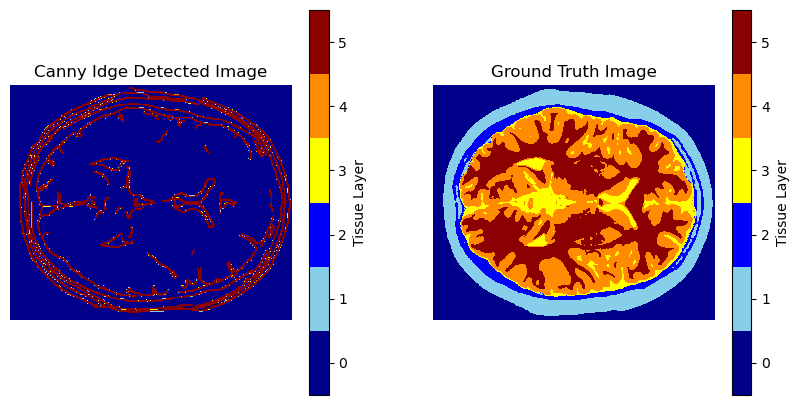

In [208]:
image = normalize_array(mri_slices[:,:,0])
ground_truth = segmented_slices[:,:,0]

# Assuming 'image' is your 2D NumPy array representing the grayscale image

# Apply Canny edge detection
edges = cv2.Canny(image.astype(np.uint8), 100, 200)  # Adjust thresholds as needed
#colored_image_canny = grayscale_to_colored(edges, cmap, labels)
#colored_image_gt= grayscale_to_colored(ground_truth, cmap, labels)
#print(colored_image_canny)

# Plot the original image and its edges
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(edges, cmap=cmap)
plt.colorbar(ticks=range(6), label='Tissue Layer')
plt.clim(-0.5, 5.5)  # Ensure colorbar aligns with the discrete segments
    
plt.title('Canny Idge Detected Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ground_truth, cmap=cmap)
plt.colorbar(ticks=range(6), label='Tissue Layer')
plt.clim(-0.5, 5.5)  # Ensure colorbar aligns with the discrete segments
    
plt.title('Ground Truth Image')
plt.axis('off')

In [209]:
def canny_detector_for_dataset():
    mat_data = scipy.io.loadmat('Brain.mat')
    # Extract the MRI slices and presegmented images
    mri_slices = mat_data['T1']
    segmented_slices = mat_data['label']
    evaluation_metrices_dataset = []
    dice_coefficient_array = []
    precision_array = []
    for i in range(0,10):
        evaluation_metrices_dataset = canny_detector_per_slice(i, mri_slices, segmented_slices)
        dice_coefficient_array.append(evaluation_metrices_dataset[0])
        precision_array.append(evaluation_metrices_dataset[1])
    dice_coefficient_dataset= np.mean(dice_coefficient_array)
    precision_dataset= np.mean(precision_array)
    print("Dice coefficient of Canny edge detector  : ", dice_coefficient_dataset)
    print("Precision of Canny edge detector  : ", precision_dataset)

In [210]:
canny_detector_for_dataset()

Dice coefficient of Canny edge detector  :  0.0738071428199685
Precision of Canny edge detector  :  0.04752683902141848


In [211]:
def sobel_detector_per_slice(index, mri_slices, segmented_slices):
    image = normalize_array(mri_slices[:,:,index])
    ground_truth = segmented_slices[:,:,index]

    # Assuming 'image' is your 2D NumPy array representing the grayscale image

    # Apply Canny edge detection
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    sobel_edges = np.sqrt(sobelx**2 + sobely**2)
    #colored_image_sobel = grayscale_to_colored(sobel_edges, cmap, labels)
    #colored_image_gt= grayscale_to_colored(ground_truth, cmap, labels)
    dice_coefficient_sobel = dice_coefficient(sobel_edges, ground_truth)
    precision_sobel = precision_per_slice(sobel_edges, ground_truth)
    evaluation_metrices_sobel = []
    evaluation_metrices_sobel.append(dice_coefficient_sobel)
    evaluation_metrices_sobel.append(precision_sobel)
    #print("Dice coefficient of Canny edge detector per slice : ",dice_coefficient_canny )
    return evaluation_metrices_sobel



(-0.5, 433.5, 361.5, -0.5)

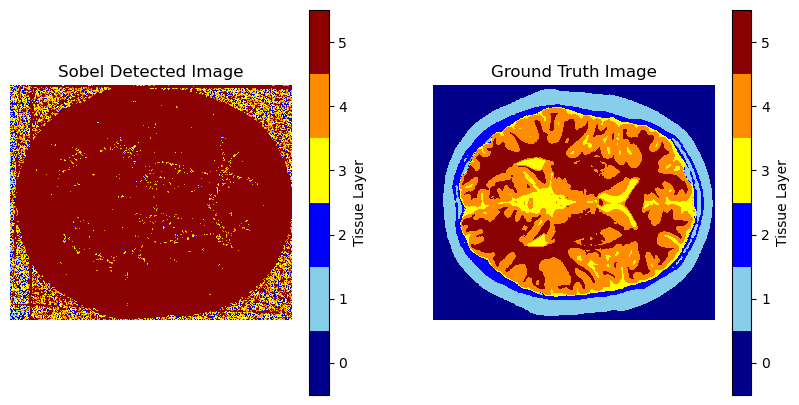

In [212]:
image = normalize_array(mri_slices[:,:,0])
ground_truth = segmented_slices[:,:,0]

# Assuming 'image' is your 2D NumPy array representing the grayscale image

# Apply Canny edge detection
sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
sobel_edges = np.sqrt(sobelx**2 + sobely**2)
#colored_image_sobel = grayscale_to_colored(sobel_edges, cmap, labels)
#colored_image_gt= grayscale_to_colored(ground_truth, cmap, labels)

# Plot the original image and its edges
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sobel_edges, cmap=cmap)
plt.colorbar(ticks=range(6), label='Tissue Layer')
plt.clim(-0.5, 5.5)  # Ensure colorbar aligns with the discrete segments
plt.title('Sobel Detected Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ground_truth, cmap=cmap)
plt.colorbar(ticks=range(6), label='Tissue Layer')
plt.clim(-0.5, 5.5)  # Ensure colorbar aligns with the discrete segments
plt.title('Ground Truth Image')
plt.axis('off')

In [213]:
def sobel_detector_for_dataset():
    mat_data = scipy.io.loadmat('Brain.mat')
    # Extract the MRI slices and presegmented images
    mri_slices = mat_data['T1']
    segmented_slices = mat_data['label']
    evaluation_metrices_dataset = []
    dice_coefficient_array = []
    precision_array = []
    for i in range(0,10):
        evaluation_metrices_dataset = sobel_detector_per_slice(i, mri_slices, segmented_slices)
        dice_coefficient_array.append(evaluation_metrices_dataset[0])
        precision_array.append(evaluation_metrices_dataset[1])
    dice_coefficient_dataset= np.mean(dice_coefficient_array)
    precision_dataset= np.mean(precision_array)
    print("Dice coefficient of Sobel edge detector  : ", dice_coefficient_dataset)
    print("Precision of Sobel edge detector  : ", precision_dataset)

In [214]:
sobel_detector_for_dataset()

Dice coefficient of Sobel edge detector  :  0.0001443954712446774
Precision of Sobel edge detector  :  0.16666666666666669


In [215]:
def prewitt_detector_per_slice(index, mri_slices, segmented_slices):
    image = normalize_array(mri_slices[:,:,index])
    ground_truth = segmented_slices[:,:,index]

    # Assuming 'image' is your 2D NumPy array representing the grayscale image

    # Apply Prewitt edge detection
    prewittx = ndimage.prewitt(image, axis=1)
    prewitty = ndimage.prewitt(image, axis=0)
    prewitt_edges = np.sqrt(prewittx**2 + prewitty**2)
    dice_coefficient_prewitt = dice_coefficient(prewitt_edges, ground_truth)
    precision_prewitt = precision_per_slice(prewitt_edges, ground_truth)
    evaluation_metrices_prewitt = []
    evaluation_metrices_prewitt.append(dice_coefficient_prewitt)
    evaluation_metrices_prewitt.append(precision_prewitt)
    #print("Dice coefficient of Canny edge detector per slice : ",dice_coefficient_canny )
    return evaluation_metrices_prewitt

(-0.5, 433.5, 361.5, -0.5)

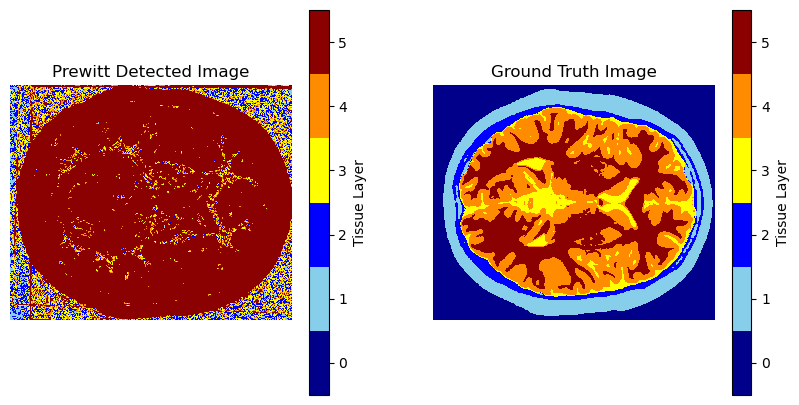

In [216]:
image = normalize_array(mri_slices[:,:,0])
ground_truth = segmented_slices[:,:,0]

# Assuming 'image' is your 2D NumPy array representing the grayscale image

# Apply Canny edge detection
prewittx = ndimage.prewitt(image, axis=1)
prewitty = ndimage.prewitt(image, axis=0)
prewitt_edges = np.sqrt(prewittx**2 + prewitty**2)
#colored_image_prewitt = grayscale_to_colored(prewitt_edges, cmap, labels)
#colored_image_gt= grayscale_to_colored(ground_truth, cmap, labels)

# Plot the original image and its edges
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(prewitt_edges, cmap=cmap)
plt.colorbar(ticks=range(6), label='Tissue Layer')
plt.clim(-0.5, 5.5)  # Ensure colorbar aligns with the discrete segments
plt.title('Prewitt Detected Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ground_truth, cmap=cmap)
plt.colorbar(ticks=range(6), label='Tissue Layer')
plt.clim(-0.5, 5.5)  # Ensure colorbar aligns with the discrete segments
plt.title('Ground Truth Image')
plt.axis('off')

In [217]:
def prewitt_detector_for_dataset():
    mat_data = scipy.io.loadmat('Brain.mat')
    # Extract the MRI slices and presegmented images
    mri_slices = mat_data['T1']
    segmented_slices = mat_data['label']
    evaluation_metrices_dataset = []
    dice_coefficient_array = []
    precision_array = []
    for i in range(0,10):
        evaluation_metrices_dataset = prewitt_detector_per_slice(i, mri_slices, segmented_slices)
        dice_coefficient_array.append(evaluation_metrices_dataset[0])
        precision_array.append(evaluation_metrices_dataset[1])
    dice_coefficient_dataset= np.mean(dice_coefficient_array)
    precision_dataset= np.mean(precision_array)
    print("Dice coefficient of Prewitt edge detector  : ", dice_coefficient_dataset)
    print("Precision of Prewitt edge detector  : ", precision_dataset)

In [218]:
prewitt_detector_for_dataset()

Dice coefficient of Prewitt edge detector  :  5.471864568358866e-06
Precision of Prewitt edge detector  :  0.08333333333333333
